# COGS 108 - Final Project

## Overview

In the social media site Reddit.com users can create posts for other Reddit users to view. On each of these posts, other users may leave comments and chat with their responses. Our group is interested in what these Redditors are saying over the months and what the most popular words of every month reveal about popular trend and contemporary events. We went through all the reddit posts in each month of 2008, and calculated the most and least used words that were unique to that month. 

## Names

- Kevin Soloway
- Timothy Bian 
- Aarushi Shah 
- San Kang
- Dingmei Gu

## Group Members IDs

- A12409011 <br/>
- A12750588 <br/>
- A15495681 <br/>
- A99139133 <br/>
- A14729954<br/>

## Research Question

Our main data science questions are:
##### Can the most commonly used words in top Reddit comments of 2008 reveal about major events and trends of the year?




### Background and Prior Work

We were inspired by various sources that asked similar questions of different data sets. For example, one article released by Mark Chopping performed research on Amazon reviews to find trending reviews and spot fake reviews. Some questions that Mark Chopping was able to answer include:

* How Do Ratings Vary With Vine Membership?
* How Do Ratings Vary With Marketplace (i.e. Region)?
* How Have Ratings Altered Over Time?
* Has Verification of Purchases Changed Over Time for Reviews?


You may read more about Mark Chopping’s findings on his article here.

Another source we used for inspiration are Word Clouds. Word Clouds are a visual way of analyzing the most popular words used in some data set. There is a website specifically made for generating word clouds, where the user inputs a website URL and it will output a word cloud of the most popular words used on that site. With our research, we are essentially creating an algorithm that would help create WordClouds for Reddit posts on a larger scale over a period of time. 

Explore Word Clouds here:
https://www.wordclouds.com/

Finally, we were inspired to find “trending” data by previous studies that explore such patterns over the years. For example, the Social Security Administration has a dedicated web-page of trending names in recent years. Trending names can be found by datasets of names of new-born babies or entire population. We wanted to translate that work into our project, and find trending words used on Reddit comments to explore how Reddit has changed over time. 

Explore Trending names here:
https://www.ssa.gov/oact/babynames/#ht=0
https://flowingdata.com/2013/07/29/the-most-trendy-names-in-us-history/


## Hypothesis


Our group predicts that the top words of a single month will be related to each other, either in sentiment or topic. For example, an example of a group of popular words during a month could be “Trump”, “election”, “twitter”, etc. We believe that this would be the case because usually every month there is a different trending topic that will result in several reddit posts. As a result, the most commonly used words unique to that specific month would be related to each other. 

## Dataset

Here is the source of our datasets: http://files.pushshift.io/reddit/comments/

In the data source, the comments are compressed and collected by month using the Reddit API. For each of these compressed files, there are hundreds of millions of observations that are comments made by Redditors. These files are compressed by month and individual comments are presented in JSON format such as the one below.  In these comments, a plethora of metadata is associated with the comment body that are very useful variables for analysis. For instance, the below comment contains information such as the score (by votes), the user name, the creation date, and the subreddit ID. There are files for comments ranging from December 2015 to February 2019. While we have access to millions of comments and data, we will only be looking at January 2008 - December 2008.

Here is a data sample from the dataset:
** Important tags to consider: “subreddit_id”, “body”, “author” **

```JSON
{"created_utc":1134365725,"author_flair_css_class":null,"score":1,"ups":1,"subreddit":"reddit.com","stickied":false,"link_id":"t3_17866","subreddit_id":"t5_6","controversiality":0,"body":"The site states \"What can I use it for? Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more...\", just like any other new breeed of sites that want us to store everything we have on the web. And they even guarantee multiple levels of security and encryption etc. But what prevents these web site operators fom accessing and/or stealing Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more, for competitive or personal gains...? I am pretty sure that most of them are honest, but what's there to prevent me from setting up a good useful site and stealing all your data? Call me paranoid - I am.","retrieved_on":1473738411,"distinguished":null,"gilded":0,"id":"c14","edited":false,"parent_id":"t3_17866","author":"zse7zse","author_flair_text":null}
```

### Special focus on 2008 comments

For the purpose of time and resource, we will only analyze 2008 comments. This is mostly due to the fact that Reddit have grown exponentially - even for 2008 the comments size are multile gbs (which require days to process!).

## Setup

Now we will begin processing our data set. We shall first import the appropriate libraries that we will use for data cleaning and plotting.

In [1]:
import bz2
import multiprocessing
import numpy
from collections import defaultdict
from collections import Counter
import nltk
import string
from nltk.stem.porter import *
import operator
import math
from textblob import TextBlob as tb
import pandas as pd
import json
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /Users/san/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/san/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/san/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning

We used Natural Language Toolkit to clean up our dataset. We first used SnowballStemmer for English to remove morphological affixes from words in each comment, leaving only the word stem. Next, we used nltk.wordpunct_tokenize() which takes corpus of text and splits it into tokens, then, we used stop words of English, nltk.corpus.words.words() to filter out the non-English words and stop words which are not helpful for our analysis.

In [2]:
def parseBzData(f):
    source_file = bz2.BZ2File(f, "r")
    comment_body = []
    for line in source_file:
        json_line = json.loads(line.decode())
        # Drop user name of comment author
        if "author" in json_line:
            del json_line["author"]
        if "body" in json_line and json_line["score"] >= 0:
            comment_body.append(json_line["body"])
    return comment_body

In [3]:
stemmer = SnowballStemmer("english")
stopwords_set = set(stopwords.words('english'))
words = set(nltk.corpus.words.words())

In [4]:
def clean_comments(comment_body):
    comment_list = []
    cache = ''
    for comment in comment_body:
        comment = stemmer.stem(comment)
        comment_cleaned = " ".join(w for w in nltk.wordpunct_tokenize(comment) if w.lower() in words and len(w) > 1 and w not in stopwords_set)
        comment_list.append(stemmer.stem(comment_cleaned))
        cache += (" " + stemmer.stem(comment_cleaned))
    return cache

In [5]:
print("Start processing 12 months' files...")
all_documents = []
for i in ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]:
    print("loading data for month " + str(i))
    all_documents.append(clean_comments(parseBzData('RC_2008-' + i + '.bz2')))

print("Done processing data")

Start processing 12 months' files...
loading data for month 01
loading data for month 02
loading data for month 03
loading data for month 04
loading data for month 05
loading data for month 06
loading data for month 07
loading data for month 08
loading data for month 09
loading data for month 10
loading data for month 11
loading data for month 12
Done processing data


## Extracting TFIDF For Positive Comments

To extract TF/IDF, we need to calculate IDF for each word and create a dictionary which stores the word as key and its IDF result as the value. The IDF value will decrease the weight for commonly used words and increase the weight for words that are not used very much in the whole year of 2008. For each month, we calculated the TF/IDF by multiplying the frequency of each word in the month and the IDF value of the word.

In [9]:
def generateWordCount(data):
    word_count = defaultdict(int)
    counter = 0
    for d in data:
        counter += 1
        print("loading data for month " + str(counter))
        c = set(list(tb(d).words))
        for w in c:
            word_count[w] += 1
    return word_count

In [10]:
word_count = generateWordCount(all_documents)

loading data for month 1
loading data for month 2
loading data for month 3
loading data for month 4
loading data for month 5
loading data for month 6
loading data for month 7
loading data for month 8
loading data for month 9
loading data for month 10
loading data for month 11
loading data for month 12


In [11]:
len(word_count)

68469

In [12]:
all_words = [tb(d) for d in all_documents]

In [13]:
def getIdf(term, words):
    term_counter = word_count[term]
    if term_counter == 0:
        return 0
    else:
        return math.log10(len(words) / term_counter)

def getTfidf(term, review, words):
    tf = review.words.count(term)
    tfidf = tf * word_idf[term]
    return tfidf

In [14]:
word_idf = defaultdict(int)
counter = 0
for w in word_count.keys():
    counter += 1
    if counter % 5000 == 0:
        print("working on idf: " + str(counter))
    word_idf[w] = getIdf(w, all_words)

working on idf: 5000
working on idf: 10000
working on idf: 15000
working on idf: 20000
working on idf: 25000
working on idf: 30000
working on idf: 35000
working on idf: 40000
working on idf: 45000
working on idf: 50000
working on idf: 55000
working on idf: 60000
working on idf: 65000


In [15]:
def generateMonthlyTfidf(index):
    print("generating tf-idf for index: " + str(index))
    words = all_words[index]
    tfidf_dict = defaultdict(int)
    counter = 0
    for w in word_count.keys():
        
        tfidf_dict[w] = getTfidf(w, words, all_words)
    print("finish generating tf-idf for index: " + str(index))
    return tfidf_dict

In [16]:
def transform_apply_result(input_list):
    result_list = []    
    for i in range(len(input_list)):
        result_list.append(input_list[i].get())
    return result_list

In [17]:
tf_idf_work_pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-7)
tf_idf_work_result_temp = []

for i in range(0,12):
    sample_result = tf_idf_work_pool.apply_async(generateMonthlyTfidf, (i, ))
    tf_idf_work_result_temp.append(sample_result)

tf_idf_work_pool.close()
tf_idf_work_pool.join()

tf_idf_work_result = transform_apply_result(tf_idf_work_result_temp)

generating tf-idf for index: 0
generating tf-idf for index: 2
generating tf-idf for index: 1
generating tf-idf for index: 3
generating tf-idf for index: 4
finish generating tf-idf for index: 1
generating tf-idf for index: 5
finish generating tf-idf for index: 2
generating tf-idf for index: 6
finish generating tf-idf for index: 0
generating tf-idf for index: 7
finish generating tf-idf for index: 3
generating tf-idf for index: 8
finish generating tf-idf for index: 4
generating tf-idf for index: 9
finish generating tf-idf for index: 5
generating tf-idf for index: 10
finish generating tf-idf for index: 7
generating tf-idf for index: 11
finish generating tf-idf for index: 6
finish generating tf-idf for index: 8
finish generating tf-idf for index: 9
finish generating tf-idf for index: 10
finish generating tf-idf for index: 11


In [18]:
word_tfidf_sorted_list = []
for i in range(0,12):
    word_tfidf_sorted_list.append(sorted(tf_idf_work_result[i].items(), key=lambda kv: -kv[1]))

### Sorted top frequent words of each month

Now that we have extracted all of our words following TFIDF method, we will sort the result and print out the top 50 for each month.

In [19]:
word_tfidf_sorted_list[0][:50]

[('lutetium', 11.672268755754654),
 ('netsuke', 10.837079843903323),
 ('cusec', 10.79181246047625),
 ('bogard', 9.712631214428624),
 ('inflector', 9.337815004603723),
 ('amoralist', 9.030899869919436),
 ('mensal', 8.633449968380999),
 ('attestation', 8.588182584953923),
 ('vardy', 8.55966375422008),
 ('triolet', 7.003361253452793),
 ('gur', 6.996569250064796),
 ('lecker', 6.475087476285749),
 ('tulle', 6.475087476285749),
 ('strick', 6.463591109097303),
 ('transvaal', 6.225210003069149),
 ('tusked', 6.225210003069149),
 ('bobbin', 5.987102807893162),
 ('carty', 5.395906230238125),
 ('herbalism', 5.383913738767463),
 ('rennet', 4.942746142250878),
 ('parasitosis', 4.915747326700727),
 ('antitax', 4.3167249841904995),
 ('paramagnet', 4.3167249841904995),
 ('overcount', 4.3167249841904995),
 ('japonica', 4.3167249841904995),
 ('quag', 4.214419939295737),
 ('milkweed', 4.214419939295737),
 ('varna', 4.182323658827666),
 ('repealer', 3.8907562519182184),
 ('borehole', 3.8907562519182184),
 

In [20]:
word_tfidf_sorted_list[1][:50]

[('unfirm', 91.0436962948863),
 ('unpledged', 10.533744271501558),
 ('hydrazine', 10.23501985257536),
 ('anosmic', 8.633449968380999),
 ('alcalde', 8.633449968380999),
 ('ruga', 7.554268722333374),
 ('urticaria', 7.224719895935548),
 ('poesy', 7.224013592520515),
 ('ilex', 7.003361253452793),
 ('moksha', 6.679697566075274),
 ('bours', 6.622659904607587),
 ('nonfederal', 6.475087476285749),
 ('fidicinal', 6.475087476285749),
 ('micropsia', 6.475087476285749),
 ('streck', 6.475087476285749),
 ('superdelegate', 6.04616974230396),
 ('quadriplegia', 6.020599913279624),
 ('stereopsis', 5.7254550566359494),
 ('nudibranch', 5.322957383962485),
 ('grantee', 4.942746142250878),
 ('crossbill', 4.3167249841904995),
 ('bookless', 4.3167249841904995),
 ('scandent', 4.3167249841904995),
 ('decapitalize', 4.3167249841904995),
 ('eyetooth', 4.3167249841904995),
 ('whitesmith', 4.3167249841904995),
 ('mense', 4.3167249841904995),
 ('histidine', 4.214419939295737),
 ('rennet', 4.182323658827666),
 ('anos

In [21]:
word_tfidf_sorted_list[2][:50]

[('heiau', 22.87827967046257),
 ('silane', 18.346081182809623),
 ('kayles', 12.450420006138298),
 ('tantrik', 11.870993706523874),
 ('outstretch', 10.115966254987367),
 ('bubo', 10.115966254987367),
 ('circumcenter', 9.712631214428624),
 ('phonautogram', 7.554268722333374),
 ('destructivity', 7.554268722333374),
 ('boatman', 7.003361253452793),
 ('pelorian', 6.475087476285749),
 ('anaphora', 6.020599913279624),
 ('collinear', 6.020599913279624),
 ('surah', 5.458829030726118),
 ('aluminothermic', 5.418539921951662),
 ('reductional', 5.395906230238125),
 ('croucher', 5.395906230238125),
 ('amusia', 5.395906230238125),
 ('divisionist', 4.668907502301861),
 ('diamondiferous', 4.3167249841904995),
 ('visitatorial', 4.3167249841904995),
 ('ocellated', 4.3167249841904995),
 ('precertification', 4.3167249841904995),
 ('dedifferentiate', 4.3167249841904995),
 ('sunniness', 4.3167249841904995),
 ('sawt', 4.3167249841904995),
 ('phonautograph', 4.3167249841904995),
 ('diuresis', 4.316724984190499

In [22]:
word_tfidf_sorted_list[3][:50]

[('mogo', 12.882273877430885),
 ('strucken', 7.554268722333374),
 ('spaid', 7.003361253452793),
 ('scops', 6.475087476285749),
 ('reflog', 6.020599913279624),
 ('unintimidated', 5.447058752685505),
 ('tiza', 5.395906230238125),
 ('subrogation', 5.248333801916287),
 ('redback', 4.942746142250878),
 ('charism', 4.668907502301861),
 ('kayles', 4.668907502301861),
 ('bolero', 4.515449934959718),
 ('crepuscule', 4.3167249841904995),
 ('fastidiousness', 4.3167249841904995),
 ('caranna', 4.3167249841904995),
 ('oxyacetylene', 4.3167249841904995),
 ('canty', 4.3167249841904995),
 ('corsage', 4.214419939295737),
 ('lave', 4.214419939295737),
 ('diffusely', 3.8907562519182184),
 ('realest', 3.8169700377572995),
 ('unpledged', 3.745331296533887),
 ('tania', 3.697916440169306),
 ('flagellum', 3.6232233616406977),
 ('acquirement', 3.612359947967774),
 ('schlieren', 3.612359947967774),
 ('alar', 3.339848783037637),
 ('shab', 3.2375437381428744),
 ('pedunculate', 3.2375437381428744),
 ('durbar', 3.23

In [23]:
word_tfidf_sorted_list[4][:50]

[('palfrey', 20.36523892490301),
 ('ingle', 15.05149978319906),
 ('plugboard', 9.712631214428624),
 ('yark', 9.712631214428624),
 ('percolation', 7.781512503836437),
 ('huddler', 7.224719895935548),
 ('gladiatrix', 6.475087476285749),
 ('glioma', 5.447058752685505),
 ('stereogram', 5.418539921951662),
 ('doubleton', 5.395906230238125),
 ('mnemonist', 5.395906230238125),
 ('tarpon', 4.942746142250878),
 ('filly', 4.816479930623699),
 ('melos', 4.3167249841904995),
 ('dactylic', 4.3167249841904995),
 ('unpartitioned', 4.3167249841904995),
 ('intussusception', 4.3167249841904995),
 ('dural', 4.3167249841904995),
 ('explanative', 4.3167249841904995),
 ('cicerone', 4.3167249841904995),
 ('laminitis', 4.3167249841904995),
 ('endocranial', 4.3167249841904995),
 ('rima', 4.294091292476962),
 ('mycologist', 4.214419939295737),
 ('tuath', 4.214419939295737),
 ('leaven', 4.213497708600623),
 ('semiannual', 3.8907562519182184),
 ('antinomy', 3.8907562519182184),
 ('sialic', 3.8907562519182184),
 (

In [24]:
word_tfidf_sorted_list[5][:50]

[('caban', 12.950174952571498),
 ('caryophyllene', 10.89411750537101),
 ('citrate', 10.03720176617383),
 ('brachialis', 9.712631214428624),
 ('oxyhydrogen', 9.632959861247398),
 ('callipygian', 9.50528104279015),
 ('squirrelfish', 9.156745470895425),
 ('borsch', 7.224719895935548),
 ('knighthood', 7.0224961810010385),
 ('misleader', 6.475087476285749),
 ('designable', 6.475087476285749),
 ('trunnion', 6.475087476285749),
 ('coker', 6.225210003069149),
 ('sloop', 6.0833798673856965),
 ('geoduck', 5.852080150834198),
 ('kinase', 5.447058752685505),
 ('nostic', 5.447058752685505),
 ('paraboloid', 5.447058752685505),
 ('peiser', 5.418539921951662),
 ('wealthiness', 5.395906230238125),
 ('lunes', 5.395906230238125),
 ('thujone', 5.322957383962485),
 ('arrestor', 5.248333801916287),
 ('banky', 5.248333801916287),
 ('lory', 5.248333801916287),
 ('boric', 4.771212547196624),
 ('hadrosaur', 4.668907502301861),
 ('haunter', 4.668907502301861),
 ('tillage', 4.562534900539273),
 ('phosphocreatine'

In [25]:
word_tfidf_sorted_list[6][:50]

[('awning', 14.279075568035443),
 ('glub', 9.363328241334717),
 ('opalesque', 8.633449968380999),
 ('jazzer', 8.633449968380999),
 ('aspartate', 8.428839878591473),
 ('concentrator', 8.426995417201246),
 ('coprolalia', 7.633940075514599),
 ('monkish', 6.679697566075274),
 ('phosphorescence', 6.622659904607587),
 ('boxwood', 6.475087476285749),
 ('insole', 6.475087476285749),
 ('paramorphism', 6.475087476285749),
 ('bouldering', 6.321629908943605),
 ('blatter', 6.225210003069149),
 ('waterflood', 6.225210003069149),
 ('pectus', 6.202576311355612),
 ('endometrial', 6.020599913279624),
 ('plasmodium', 5.418539921951662),
 ('solvation', 5.395906230238125),
 ('jigginess', 5.395906230238125),
 ('implead', 5.395906230238125),
 ('selenide', 5.395906230238125),
 ('unbraced', 5.395906230238125),
 ('riddler', 5.328187085405365),
 ('eucharistic', 5.248333801916287),
 ('committeeman', 4.816479930623699),
 ('conceptus', 4.771212547196624),
 ('dendritic', 4.771212547196624),
 ('methylene', 4.77121254

In [26]:
word_tfidf_sorted_list[7][:50]

[('perchlorate', 24.68445964444646),
 ('saddleback', 15.968872151887453),
 ('rakan', 15.108537444666748),
 ('associational', 15.108537444666748),
 ('baku', 10.64591476792497),
 ('antireligion', 10.536049848239342),
 ('spitz', 10.065577859434821),
 ('cockily', 9.712631214428624),
 ('leal', 7.826779887263511),
 ('perchlor', 7.781512503836437),
 ('bentonite', 7.633940075514599),
 ('anode', 7.60422483423212),
 ('beal', 7.60422483423212),
 ('wawah', 7.554268722333374),
 ('babby', 7.3687693734329525),
 ('nothingism', 7.224719895935548),
 ('easement', 6.5153765850602054),
 ('coatee', 6.475087476285749),
 ('pandan', 6.225210003069149),
 ('winglet', 6.225210003069149),
 ('mogo', 6.202576311355612),
 ('steerable', 6.020599913279624),
 ('awakener', 5.447058752685505),
 ('perfective', 5.447058752685505),
 ('doser', 5.395906230238125),
 ('nulliparous', 5.395906230238125),
 ('binaural', 5.122488200940297),
 ('vitiligo', 4.816479930623699),
 ('fagging', 4.816479930623699),
 ('northbound', 4.754463994

In [27]:
word_tfidf_sorted_list[8][:50]

[('diverticulosis', 32.682352516113035),
 ('palisading', 16.341176258056517),
 ('actinic', 16.341176258056517),
 ('focally', 16.341176258056517),
 ('dermatopathology', 16.341176258056517),
 ('okapi', 15.968872151887453),
 ('borosilicate', 15.05149978319906),
 ('undelayed', 13.847379800543136),
 ('reviewable', 12.041199826559248),
 ('colley', 11.870993706523874),
 ('fortis', 11.026126009636576),
 ('adenomatous', 10.973788858552236),
 ('entopic', 10.79181246047625),
 ('chicane', 10.019546349112911),
 ('dorsum', 10.019546349112911),
 ('dermis', 9.831494653401453),
 ('chrom', 9.14483173523474),
 ('squirrelfish', 8.980654211839743),
 ('homopolar', 8.633449968380999),
 ('pinax', 8.588182584953923),
 ('squamous', 7.5719241393942935),
 ('detainable', 7.554268722333374),
 ('noncompli', 7.156818820794936),
 ('euphonious', 7.003361253452793),
 ('precancerous', 6.923689900271568),
 ('babby', 6.915306642760155),
 ('resection', 6.622659904607587),
 ('conservatorship', 6.622659904607587),
 ('melamine

In [28]:
word_tfidf_sorted_list[9][:50]

[('diverticulosis', 65.36470503222607),
 ('palisading', 32.682352516113035),
 ('actinic', 32.682352516113035),
 ('focally', 32.682352516113035),
 ('dermatopathology', 32.682352516113035),
 ('jiff', 25.046903045570367),
 ('stingo', 20.47003970515072),
 ('adenomatous', 20.039092698225822),
 ('dorsum', 20.039092698225822),
 ('dermis', 19.662989306802906),
 ('squamous', 15.496030796899948),
 ('delusory', 14.029356198619123),
 ('resection', 13.847379800543136),
 ('melamine', 13.368444817088092),
 ('theriaca', 12.950174952571498),
 ('precancerous', 12.64325981788721),
 ('neuroma', 12.64325981788721),
 ('awee', 12.405152622711224),
 ('polyp', 9.831494653401453),
 ('dermal', 9.831494653401453),
 ('freath', 9.712631214428624),
 ('folksiness', 9.632959861247398),
 ('muslin', 9.185024541524479),
 ('epithelial', 7.924106657505655),
 ('misogynic', 7.826779887263511),
 ('coble', 7.826779887263511),
 ('malm', 7.554268722333374),
 ('coistril', 7.554268722333374),
 ('tuath', 7.224719895935548),
 ('nida

In [29]:
word_tfidf_sorted_list[10][:50]

[('awee', 128.34561751958918),
 ('keratinization', 28.627275283179745),
 ('melamine', 28.111215736867482),
 ('alanyl', 20.504443674904874),
 ('valyl', 16.187718690714373),
 ('leucyl', 15.108537444666748),
 ('telestial', 15.108537444666748),
 ('nonya', 12.950174952571498),
 ('narwhal', 12.243996187613392),
 ('syncope', 10.79181246047625),
 ('podesta', 10.115966254987367),
 ('circumciser', 10.019546349112911),
 ('aesthetical', 9.632959861247398),
 ('narwh', 9.50528104279015),
 ('undrained', 9.337815004603723),
 ('passageway', 9.030899869919436),
 ('prolyl', 8.633449968380999),
 ('glycolaldehyde', 8.633449968380999),
 ('melamin', 8.588182584953923),
 ('reformism', 8.428839878591473),
 ('monogamic', 7.781512503836437),
 ('mia', 7.781512503836437),
 ('hypospadias', 7.554268722333374),
 ('providentialism', 7.554268722333374),
 ('burao', 7.554268722333374),
 ('noddy', 7.224719895935548),
 ('gerontocracy', 7.003361253452793),
 ('bassoon', 6.843802350808908),
 ('madrasah', 6.78841297496767),
 (

In [30]:
word_tfidf_sorted_list[11][:50]

[('prorogue', 93.88876840614337),
 ('tharm', 19.42526242885725),
 ('narwhal', 17.11660691533709),
 ('saturnalia', 14.449439791871097),
 ('dartos', 13.847379800543136),
 ('eutectic', 13.847379800543136),
 ('rickey', 13.83651638687021),
 ('backwardation', 13.83651638687021),
 ('cummingtonite', 12.950174952571498),
 ('prorogation', 12.64325981788721),
 ('nonmoral', 11.870993706523874),
 ('parhelic', 11.870993706523874),
 ('fawny', 10.115966254987367),
 ('mulk', 9.712631214428624),
 ('graupel', 9.712631214428624),
 ('diaconate', 9.712631214428624),
 ('snozzle', 9.712631214428624),
 ('shaitan', 9.337815004603723),
 ('keratinization', 9.065303839673586),
 ('learnedness', 8.633449968380999),
 ('melamine', 8.620772825972695),
 ('scrapy', 8.55966375422008),
 ('buckie', 8.428839878591473),
 ('narwh', 7.9844360759437265),
 ('supernature', 7.633940075514599),
 ('greensand', 7.554268722333374),
 ('yair', 7.554268722333374),
 ('saturnalian', 7.554268722333374),
 ('superordinate', 7.554268722333374),

## Extracting TFIDF for Negative Comments 

We will repeat the process for negative comments.

However, due to the size of the data set and the analysis required, the TFIDF method takes a really long time to rerun. Because we ran the method on a separate file to save time. We will manually save the results here instead of rerunning the program for negative comments.

The function below is the same as the one above except we have changed the scoring comparison to < 0 in order to only look at negative comments.

In [2]:
def parseBzData(f):
    source_file = bz2.BZ2File(f, "r")
    comment_body = []
    for line in source_file:
        json_line = json.loads(line.decode())
        # Drop user name of comment author
        if "author" in json_line:
            del json_line["author"]
        if "body" in json_line and json_line["score"] < 0:
            comment_body.append(json_line["body"])
    return comment_body

With the above change, we ran the same functions and retrieved the top 50 frequent words for negative comments.

## Visualizing and Analyzing the Results

### Prepping the output data from each month

First, let us quantify our outputs into variables for convenience. This is mostly done due to the size of our data set and the processing power required to run the given data. It will be too time (and resource!) intensive to rerun our data so we will simply save the output directly into variables for further analysis.

In [2]:
jan_pos_2008 = [('lutetium', 11.672268755754654), ('netsuke', 10.837079843903323), ('cusec', 10.79181246047625), ('bogard', 9.712631214428624), ('inflector', 9.337815004603723), ('amoralist', 9.030899869919436), ('mensal', 8.633449968380999), ('attestation', 8.588182584953923), ('vardy', 8.55966375422008), ('triolet', 7.003361253452793), ('gur', 6.996569250064796),
 ('lecker', 6.475087476285749), ('tulle', 6.475087476285749), ('strick', 6.463591109097303), ('transvaal', 6.225210003069149), ('tusked', 6.225210003069149), ('bobbin', 5.987102807893162), ('carty', 5.395906230238125), ('herbalism', 5.383913738767463), ('rennet', 4.942746142250878), ('parasitosis', 4.915747326700727), ('antitax', 4.3167249841904995), ('paramagnet', 4.3167249841904995), ('overcount', 4.3167249841904995), ('japonica', 4.3167249841904995), ('quag', 4.214419939295737), ('milkweed', 4.214419939295737), ('varna', 4.182323658827666), ('repealer', 3.8907562519182184), ('borehole', 3.8907562519182184), ('rumney', 3.8907562519182184), ('abac', 3.8907562519182184), ('katydid', 3.8169700377572995), ('kik', 3.80211241711606),
 ('uncommit', 3.745331296533887), ('ontogeny', 3.612359947967774), ('junt', 3.612359947967774), ('rishi', 3.612359947967774), ('unsilenced', 3.612359947967774), ('miscount', 3.5112480905005192), ('kaffiyeh', 3.339848783037637), ('shipboard', 3.339848783037637), ('accommodative', 3.2375437381428744), ('earthquaking', 3.2375437381428744), ('unie', 3.2375437381428744), ('anticlerical', 3.2375437381428744), ('polyploid', 3.2375437381428744), ('hydatid', 3.2375437381428744), ('zoosperm', 3.2375437381428744), ('bota', 3.2375437381428744)] 

feb_pos_2008 = [('unfirm', 91.0436962948863), ('unpledged', 10.533744271501558), ('hydrazine', 10.23501985257536), ('anosmic', 8.633449968380999), ('alcalde', 8.633449968380999), ('ruga', 7.554268722333374),
 ('urticaria', 7.224719895935548), ('poesy', 7.224013592520515), ('ilex', 7.003361253452793),
 ('moksha', 6.679697566075274), ('bours', 6.622659904607587), ('nonfederal', 6.475087476285749), ('fidicinal', 6.475087476285749), ('micropsia', 6.475087476285749), ('streck', 6.475087476285749), ('superdelegate', 6.04616974230396), ('quadriplegia', 6.020599913279624), ('stereopsis', 5.7254550566359494), ('nudibranch', 5.322957383962485), ('grantee', 4.942746142250878), ('crossbill', 4.3167249841904995), ('bookless', 4.3167249841904995), ('scandent', 4.3167249841904995), ('decapitalize', 4.3167249841904995), ('eyetooth', 4.3167249841904995), ('whitesmith', 4.3167249841904995), ('mense', 4.3167249841904995), ('histidine', 4.214419939295737), ('rennet', 4.182323658827666), ('anosmia', 3.8169700377572995), ('superdeleg', 3.745331296533887), ('ethnocracy', 3.612359947967774), ('hydroscopic', 3.612359947967774), ('waterspout', 3.612359947967774), ('willey', 3.5218251811136247), ('xylitol', 3.373345888424098), ('untasty', 3.339848783037637), ('ubiety', 3.2375437381428744), ('alkene', 3.2375437381428744), ('ivybells', 3.2375437381428744), ('tearage', 3.2375437381428744), ('hyperborean', 3.2375437381428744), ('trioxide', 3.2375437381428744), ('innominate', 3.2375437381428744), ('untellable', 3.2375437381428744), ('sitosterol', 3.2375437381428744), ('elkhorn', 3.2375437381428744), ('clockface', 3.2375437381428744), ('seigneurial', 3.2375437381428744), ('carper', 3.1696426630022625)] 

mar_pos_2008 = [('heiau', 22.87827967046257), ('silane', 18.346081182809623), ('kayles', 12.450420006138298), ('tantrik', 11.870993706523874), ('outstretch', 10.115966254987367), ('bubo', 10.115966254987367), ('circumcenter', 9.712631214428624), ('phonautogram', 7.554268722333374), ('destructivity', 7.554268722333374), ('boatman', 7.003361253452793), ('pelorian', 6.475087476285749), ('anaphora', 6.020599913279624), ('collinear', 6.020599913279624), ('surah', 5.458829030726118), ('aluminothermic', 5.418539921951662), ('reductional', 5.395906230238125), ('croucher', 5.395906230238125), ('amusia', 5.395906230238125), ('divisionist', 4.668907502301861), ('diamondiferous', 4.3167249841904995), ('visitatorial', 4.3167249841904995), ('ocellated', 4.3167249841904995), ('precertification', 4.3167249841904995), ('dedifferentiate', 4.3167249841904995), ('sunniness', 4.3167249841904995), ('sawt', 4.3167249841904995), ('phonautograph', 4.3167249841904995), ('diuresis', 4.3167249841904995), ('causey', 4.294091292476962), ('colitis', 4.27578728657174), ('quatre', 4.214419939295737), ('charism', 3.8907562519182184), ('muscadine', 3.8907562519182184), ('unpledged', 3.745331296533887), ('spitz', 3.745331296533887), ('karyotype', 3.612359947967774), ('gratu', 3.612359947967774), ('sortition', 3.498284625032398), ('revote', 3.498284625032398), ('cretinism', 3.3113299523037933), ('macaw', 3.3113299523037933), ('lovelock', 3.248407151815798), ('organismal', 3.2375437381428744), ('perjurous', 3.2375437381428744), ('superavit', 3.2375437381428744), ('deerhound', 3.2375437381428744), ('tambor', 3.2375437381428744), ('tanh', 3.2375437381428744), ('tilter', 3.2375437381428744), ('spode', 3.2375437381428744)] 

apr_pos_2008 = [('mogo', 12.882273877430885), ('strucken', 7.554268722333374), ('spaid', 7.003361253452793), ('scops', 6.475087476285749), ('reflog', 6.020599913279624), ('unintimidated', 5.447058752685505), ('tiza', 5.395906230238125),
 ('subrogation', 5.248333801916287), ('redback', 4.942746142250878), ('charism', 4.668907502301861), ('kayles', 4.668907502301861), ('bolero', 4.515449934959718), ('crepuscule', 4.3167249841904995), ('fastidiousness', 4.3167249841904995), ('caranna', 4.3167249841904995), ('oxyacetylene', 4.3167249841904995), ('canty', 4.3167249841904995), ('corsage', 4.214419939295737), ('lave', 4.214419939295737),
 ('diffusely', 3.8907562519182184), ('realest', 3.8169700377572995), ('unpledged', 3.745331296533887), ('tania', 3.697916440169306), ('flagellum', 3.6232233616406977), ('acquirement', 3.612359947967774), ('schlieren', 3.612359947967774), ('alar', 3.339848783037637),
 ('shab', 3.2375437381428744), ('pedunculate', 3.2375437381428744), ('durbar', 3.2375437381428744), ('matureness', 3.2375437381428744), ('palaeological', 3.2375437381428744), ('photoimpression', 3.2375437381428744), ('virescence', 3.2375437381428744), ('asway', 3.2375437381428744), ('gleet', 3.2375437381428744), ('verjuice', 3.2375437381428744), ('contriteness', 3.2375437381428744), ('lipodystrophy', 3.2375437381428744), ('counterpane', 3.2375437381428744), ('raphides', 3.2375437381428744), ('salpa', 3.2375437381428744), ('enigmatically', 3.2375437381428744), ('horsy', 3.2375437381428744), ('blessedness', 3.2375437381428744), ('craniosacral', 3.2375437381428744), ('chummery', 3.2375437381428744), ('amylose', 3.2375437381428744), ('heptagon', 3.2375437381428744), ('toolmaking', 3.2375437381428744)] 

may_pos_2008 = [('palfrey', 20.36523892490301), ('ingle', 15.05149978319906), ('plugboard', 9.712631214428624), ('yark', 9.712631214428624),
 ('percolation', 7.781512503836437), ('huddler', 7.224719895935548), ('gladiatrix', 6.475087476285749), ('glioma', 5.447058752685505), ('stereogram', 5.418539921951662), ('doubleton', 5.395906230238125), ('mnemonist', 5.395906230238125), ('tarpon', 4.942746142250878), ('filly', 4.816479930623699), ('melos', 4.3167249841904995), ('dactylic', 4.3167249841904995), ('unpartitioned', 4.3167249841904995), ('intussusception', 4.3167249841904995), ('dural', 4.3167249841904995), ('explanative', 4.3167249841904995), ('cicerone', 4.3167249841904995), ('laminitis', 4.3167249841904995), ('endocranial', 4.3167249841904995), ('rima', 4.294091292476962),
 ('mycologist', 4.214419939295737), ('tuath', 4.214419939295737), ('leaven', 4.213497708600623), ('semiannual', 3.8907562519182184), ('antinomy', 3.8907562519182184), ('sialic', 3.8907562519182184), ('dioxane', 3.8907562519182184), ('belton', 3.8907562519182184), ('krome', 3.8907562519182184), ('errorist', 3.8907562519182184), ('anharmonic', 3.8907562519182184), ('directivity', 3.8907562519182184), ('polythene', 3.80211241711606), ('atchison', 3.80211241711606), ('ladybird', 3.80211241711606), ('problematize', 3.612359947967774), ('congruential', 3.612359947967774), ('kob', 3.612359947967774),
 ('hemmer', 3.612359947967774), ('olecranon', 3.612359947967774), ('tatu', 3.612359947967774),
 ('merryman', 3.339848783037637), ('kago', 3.339848783037637),
 ('scrobble', 3.339848783037637), ('eluvium', 3.339848783037637), ('scaleless', 3.2375437381428744), ('dominium', 3.2375437381428744)] 

jun_pos_2008 = [('caban', 12.950174952571498), ('caryophyllene', 10.89411750537101), ('citrate', 10.03720176617383), ('brachialis', 9.712631214428624), ('oxyhydrogen', 9.632959861247398), ('callipygian', 9.50528104279015), ('squirrelfish', 9.156745470895425), ('borsch', 7.224719895935548), ('knighthood', 7.0224961810010385), ('misleader', 6.475087476285749), ('designable', 6.475087476285749), ('trunnion', 6.475087476285749), ('coker', 6.225210003069149), ('sloop', 6.0833798673856965), ('geoduck', 5.852080150834198), ('kinase', 5.447058752685505), ('nostic', 5.447058752685505), ('paraboloid', 5.447058752685505), ('peiser', 5.418539921951662), ('wealthiness', 5.395906230238125), ('lunes', 5.395906230238125), ('thujone', 5.322957383962485), ('arrestor', 5.248333801916287), ('banky', 5.248333801916287), ('lory', 5.248333801916287),
 ('boric', 4.771212547196624), ('hadrosaur', 4.668907502301861), ('haunter', 4.668907502301861), ('tillage', 4.562534900539273), ('phosphocreatine', 4.3167249841904995), ('switchel', 4.3167249841904995), ('tripos', 4.3167249841904995), ('callipygous', 4.3167249841904995), ('everydayness', 4.3167249841904995), ('unliftable', 4.3167249841904995), ('preambulatory', 4.214419939295737), ('hadden', 4.214419939295737), ('uracil', 4.214419939295737), ('chrysalis', 4.214419939295737), ('rennet', 4.182323658827666), ('wordle', 4.182323658827666), ('fortis', 4.182323658827666), ('tala', 3.9133899436317554), ('protuberance', 3.8907562519182184), ('alexandrite', 3.8907562519182184), ('minot', 3.697916440169306), ('trekk', 3.612359947967774), ('prefatory', 3.612359947967774), ('moissanite', 3.421901175404454), ('capybara', 3.339848783037637)] 

jul_pos_2008 = [('awning', 14.279075568035443), ('glub', 9.363328241334717),
 ('opalesque', 8.633449968380999), ('jazzer', 8.633449968380999), ('aspartate', 8.428839878591473), ('concentrator', 8.426995417201246), ('coprolalia', 7.633940075514599), ('monkish', 6.679697566075274), ('phosphorescence', 6.622659904607587), ('boxwood', 6.475087476285749), ('insole', 6.475087476285749), ('paramorphism', 6.475087476285749), ('bouldering', 6.321629908943605), ('blatter', 6.225210003069149), ('waterflood', 6.225210003069149), ('pectus', 6.202576311355612), ('endometrial', 6.020599913279624), ('plasmodium', 5.418539921951662), ('solvation', 5.395906230238125), ('jigginess', 5.395906230238125), ('implead', 5.395906230238125), ('selenide', 5.395906230238125), ('unbraced', 5.395906230238125), ('riddler', 5.328187085405365), ('eucharistic', 5.248333801916287), ('committeeman', 4.816479930623699), ('conceptus', 4.771212547196624), ('dendritic', 4.771212547196624), ('methylene', 4.771212547196624), ('epigenetic', 4.754463994503394), ('chined', 4.668907502301861), ('pilonidal', 4.562534900539273), ('hyperpigmentation', 4.3167249841904995), ('icebound', 4.3167249841904995), ('pitchstone', 4.3167249841904995), ('percher', 4.3167249841904995), ('syzygium', 4.3167249841904995), ('girdling', 4.3167249841904995), ('petrosa', 4.3167249841904995), ('killdeer', 4.3167249841904995), ('batfish', 4.3167249841904995), ('unmended', 4.3167249841904995), ('overspeculation', 4.294091292476962), ('skidder', 4.214419939295737), ('loach', 4.214419939295737), ('asherah', 4.214419939295737), ('croydon', 4.213497708600623), ('arginine', 4.182323658827666), ('grantee', 4.182323658827666), ('hedonics', 4.182323658827666)] 

aug_pos_2008 = [('perchlorate', 24.68445964444646), ('saddleback', 15.968872151887453), ('rakan', 15.108537444666748), ('associational', 15.108537444666748), ('baku', 10.64591476792497), ('antireligion', 10.536049848239342), ('spitz', 10.065577859434821), ('cockily', 9.712631214428624), ('leal', 7.826779887263511), ('perchlor', 7.781512503836437), ('bentonite', 7.633940075514599), ('anode', 7.60422483423212), ('beal', 7.60422483423212),
 ('wawah', 7.554268722333374), ('babby', 7.3687693734329525), ('nothingism', 7.224719895935548), ('easement', 6.5153765850602054), ('coatee', 6.475087476285749), ('pandan', 6.225210003069149), ('winglet', 6.225210003069149), ('mogo', 6.202576311355612), ('steerable', 6.020599913279624), ('awakener', 5.447058752685505), ('perfective', 5.447058752685505), ('doser', 5.395906230238125), ('nulliparous', 5.395906230238125), ('binaural', 5.122488200940297), ('vitiligo', 4.816479930623699), ('fagging', 4.816479930623699), ('northbound', 4.754463994503394), ('aerodrome', 4.668907502301861), ('slackness', 4.668907502301861), ('curlew', 4.668907502301861), ('plosive', 4.668907502301861), ('shuttlecock', 4.515449934959718), ('unbudging', 4.3167249841904995), ('adsorbent', 4.3167249841904995), ('vespertine', 4.3167249841904995), ('roentgen', 4.3167249841904995), ('haku', 4.3167249841904995), ('rebounder', 4.3167249841904995), ('unhittable', 4.3167249841904995), ('limbus', 4.3167249841904995), ('controllably', 4.3167249841904995), ('unstamped', 4.3167249841904995), ('unpretenti', 4.3167249841904995), ('voile', 4.3167249841904995), ('broomrape', 4.294091292476962), ('kukri', 4.294091292476962), ('gude', 4.214419939295737)] 

sep_pos_2008 = [('diverticulosis', 32.682352516113035), ('palisading', 16.341176258056517), ('actinic', 16.341176258056517), ('focally', 16.341176258056517), ('dermatopathology', 16.341176258056517), ('okapi', 15.968872151887453), ('borosilicate', 15.05149978319906), ('undelayed', 13.847379800543136), ('reviewable', 12.041199826559248), ('colley', 11.870993706523874), ('fortis', 11.026126009636576), ('adenomatous', 10.973788858552236), ('entopic', 10.79181246047625), ('chicane', 10.019546349112911), ('dorsum', 10.019546349112911), ('dermis', 9.831494653401453), ('chrom', 9.14483173523474),
 ('squirrelfish', 8.980654211839743), ('homopolar', 8.633449968380999), ('pinax', 8.588182584953923), ('squamous', 7.5719241393942935), ('detainable', 7.554268722333374), ('noncompli', 7.156818820794936), ('euphonious', 7.003361253452793), ('precancerous', 6.923689900271568), ('babby', 6.915306642760155), ('resection', 6.622659904607587), ('conservatorship', 6.622659904607587), ('melamine', 6.621753040239896), ('hemm', 6.475087476285749),
 ('thiocyanide', 6.475087476285749), ('coltsfoot', 6.475087476285749), ('steamship', 6.463591109097303), ('matsu', 6.463591109097303), ('neuroma', 6.321629908943605), ('carlie', 6.225210003069149), ('piratery', 6.020599913279624), ('escapement', 6.020599913279624), ('beshear', 5.70316862567409), ('zapatero', 5.7010497154289865), ('polyp', 5.61799694480083),
 ('centum', 5.418539921951662), ('scoter', 5.395906230238125), ('ontologic', 5.395906230238125), ('hoptoad', 5.395906230238125), ('oread', 5.395906230238125), ('unreadiness', 5.395906230238125), ('muslin', 5.384324731238488), ('dovecot', 5.322957383962485), ('dermal', 5.149830532734095)] 

oct_pos_2008 = [('diverticulosis', 65.36470503222607), ('palisading', 32.682352516113035), ('actinic', 32.682352516113035), ('focally', 32.682352516113035), ('dermatopathology', 32.682352516113035), ('jiff', 25.046903045570367), ('stingo', 20.47003970515072), ('adenomatous', 20.039092698225822), ('dorsum', 20.039092698225822), ('dermis', 19.662989306802906), ('squamous', 15.496030796899948), ('delusory', 14.029356198619123), ('resection', 13.847379800543136), ('melamine', 13.368444817088092), ('theriaca', 12.950174952571498), ('precancerous', 12.64325981788721), ('neuroma', 12.64325981788721), ('awee', 12.405152622711224), ('polyp', 9.831494653401453), ('dermal', 9.831494653401453), ('freath', 9.712631214428624), ('folksiness', 9.632959861247398), ('muslin', 9.185024541524479), ('epithelial', 7.924106657505655), ('misogynic', 7.826779887263511), ('coble', 7.826779887263511), ('malm', 7.554268722333374), ('coistril', 7.554268722333374), ('tuath', 7.224719895935548), ('nidal', 7.224719895935548), ('exteriorization', 7.156818820794936), ('krona', 7.1215079866730955), ('carcinoma', 7.047130898238609), ('folksi', 6.843802350808908), ('belvedere', 6.78841297496767), ('cyanuric', 6.622659904607587), ('parah', 6.622659904607587), ('interbank', 6.5153765850602054), ('harn', 6.475087476285749), ('saponin', 6.475087476285749), ('compossible', 6.475087476285749), ('babby', 6.386266790308558), ('airedale', 6.225210003069149), ('glazier', 6.0833798673856965), ('feticide', 6.020599913279624), ('kronur', 6.020599913279624), ('doggon', 5.7254550566359494), ('reformism', 5.719569917615643), ('internode', 5.70316862567409), ('overlying', 5.622243147373497)] 

nov_pos_2008 = [('awee', 128.34561751958918), ('keratinization', 28.627275283179745), ('melamine', 28.111215736867482), ('alanyl', 20.504443674904874), ('valyl', 16.187718690714373), ('leucyl', 15.108537444666748), ('telestial', 15.108537444666748), ('nonya', 12.950174952571498), ('narwhal', 12.243996187613392), ('syncope', 10.79181246047625), ('podesta', 10.115966254987367), ('circumciser', 10.019546349112911), ('aesthetical', 9.632959861247398), ('narwh', 9.50528104279015), ('undrained', 9.337815004603723), ('passageway', 9.030899869919436), ('prolyl', 8.633449968380999), ('glycolaldehyde', 8.633449968380999), ('melamin', 8.588182584953923), ('reformism', 8.428839878591473), ('monogamic', 7.781512503836437), ('mia', 7.781512503836437),
 ('hypospadias', 7.554268722333374), ('providentialism', 7.554268722333374), ('burao', 7.554268722333374), ('noddy', 7.224719895935548), ('gerontocracy', 7.003361253452793), ('bassoon', 6.843802350808908), ('madrasah', 6.78841297496767), ('babby', 6.612998155644957), ('tomogram', 6.475087476285749), ('chloroquine', 6.475087476285749), ('butyrate', 6.475087476285749), ('glycyl', 6.475087476285749), ('kiva', 6.2553184377623605), ('guttersnipe', 6.225210003069149), ('voidable', 6.225210003069149), ('standish', 6.225210003069149), ('flutist', 6.225210003069149), ('scena', 6.202576311355612), ('manticore', 6.202576311355612), ('callus', 6.086163356867567), ('eliminative', 6.0833798673856965), ('constitutor', 6.020599913279624), ('astigmatism', 5.61799694480083), ('vagus', 5.458829030726118), ('aspartyl', 5.447058752685505), ('carse', 5.447058752685505), ('tiddi', 5.447058752685505), ('tablespoonful', 5.418539921951662)] 

dec_pos_2008 = [('prorogue', 93.88876840614337), ('tharm', 19.42526242885725), ('narwhal', 17.11660691533709), ('saturnalia', 14.449439791871097), ('dartos', 13.847379800543136), ('eutectic', 13.847379800543136), ('rickey', 13.83651638687021), ('backwardation', 13.83651638687021), ('cummingtonite', 12.950174952571498), ('prorogation', 12.64325981788721), ('nonmoral', 11.870993706523874), ('parhelic', 11.870993706523874), ('fawny', 10.115966254987367), ('mulk', 9.712631214428624),
 ('graupel', 9.712631214428624), ('diaconate', 9.712631214428624), ('snozzle', 9.712631214428624), ('shaitan', 9.337815004603723), ('keratinization', 9.065303839673586), ('learnedness', 8.633449968380999), ('melamine', 8.620772825972695), ('scrapy', 8.55966375422008), ('buckie', 8.428839878591473), ('narwh', 7.9844360759437265), ('supernature', 7.633940075514599), ('greensand', 7.554268722333374), ('yair', 7.554268722333374),
 ('saturnalian', 7.554268722333374), ('superordinate', 7.554268722333374), ('conky', 7.52574989159953),
 ('eggnog', 7.395832880338612), ('noncontradiction', 7.003361253452793), ('glioma', 7.003361253452793), ('solstic', 6.867559103171568), ('underconsumption', 6.843802350808908), ('meddler', 6.679697566075274), ('metrification', 6.679697566075274), ('melamin', 6.679697566075274), ('gumma', 6.475087476285749), ('hypogeum', 6.475087476285749), ('alizarin', 6.475087476285749), ('mutism', 6.225210003069149), ('moissanite', 6.0833798673856965), ('cancan', 6.020599913279624), ('parlamento', 6.020599913279624), ('physicalism', 5.987102807893162), ('aborigine', 5.780230961476612), ('deceivingly', 5.7254550566359494), ('corpuscular', 5.447058752685505), ('thermography', 5.418539921951662)] 


Lets do the same thing for the negative comments in 2008. We will make variables for the top frequency words in the negative comments and save them for future use.

In [3]:
jan_neg_2008 = [('dudley', 42.7983187711004), ('wizened', 20.911618294138332), ('biddy', 12.450420006138298), ('didle', 8.633449968380999), ('squatter', 7.633940075514599), ('oxidation', 6.225210003069149), ('willey', 5.447058752685505), ('huck', 5.149830532734095), ('concussion', 4.816479930623699), ('kik', 4.771212547196624),
 ('recount', 4.6716935168098646), ('humidity', 4.562534900539273), ('dada', 4.3167249841904995), ('flax', 4.3167249841904995), ('ullage', 4.3167249841904995), ('corrie', 4.182323658827666), ('deceiv', 3.8169700377572995), ('bulldozer', 3.5218251811136247), ('tinker', 3.5218251811136247), ('rasping', 3.2375437381428744), ('spital', 3.2375437381428744), ('sledge', 3.2375437381428744), ('dietetic', 3.2375437381428744), ('untroubled', 3.2375437381428744), ('linn', 3.2375437381428744), ('dehumidifier', 3.2375437381428744), ('payor', 3.2375437381428744), ('unassigned', 3.2375437381428744), ('rax', 3.2375437381428744), ('suttee', 3.2375437381428744), ('fluorination', 3.2375437381428744), ('terrace', 3.2375437381428744), ('plenum', 3.2375437381428744), ('tusked', 3.2375437381428744), ('clearinghouse', 3.2375437381428744), ('minot', 3.1126050015345745), ('sherry', 3.1126050015345745), ('param', 3.1126050015345745), ('televise', 3.1126050015345745), ('strictness', 3.1126050015345745)]

feb_neg_2008 = [('willey', 27.235293763427528), ('grantee', 7.554268722333374), ('idempot', 5.395906230238125), ('nonfederal', 5.395906230238125), ('marzipan', 4.3167249841904995), ('fizz', 4.214419939295737),
 ('dianetics', 3.9133899436317554), ('cordon', 3.8907562519182184), ('superdelegate', 3.8169700377572995), ('rancor', 3.8169700377572995), ('murmur', 3.80211241711606), ('rotor', 3.612359947967774), ('subcontractor', 3.2375437381428744), ('breathable', 3.010299956639812), ('ump', 3.010299956639812),
 ('naturalism', 2.8627275283179747), ('thence', 2.8627275283179747), ('demagogu', 2.6614786919812423), ('roi', 2.4987747321659985),
 ('atonement', 2.4082399653118496), ('attic', 2.4082399653118496), ('skater', 2.385606273598312), ('wynn', 2.3344537511509307), ('alms', 2.3344537511509307), ('notability', 2.3344537511509307), ('hydration', 2.3344537511509307), ('disrespectfully', 2.3344537511509307), ('hypothermia', 2.3344537511509307), ('kaiser', 2.289186367723856), ('deposition', 2.2812674502696364), ('valentine', 2.2812674502696364), ('decre', 2.1583624920952498), ('aspartic', 2.1583624920952498), ('reinsert', 2.1583624920952498), ('celeri', 2.1583624920952498), ('lactobacillus', 2.1583624920952498), ('paginate', 2.1583624920952498), ('trounce', 2.1583624920952498), ('parapleg', 2.1583624920952498), ('oner', 2.1583624920952498)] 

mar_neg_2008 = [('lina', 17.266899936761998), ('kayles', 14.449439791871097), ('asok', 9.712631214428624),
 ('homoeopathy', 5.447058752685505), ('silica', 5.418539921951662), ('lancet', 5.11750992628768), ('inhabitant', 4.771212547196624), ('colitis', 4.3167249841904995), ('integrative', 4.3167249841904995), ('presentational', 4.3167249841904995), ('donna', 4.213497708600623), ('causey', 3.612359947967774), ('hypercube', 3.2375437381428744), ('formaldehyd', 3.2375437381428744), ('nonresident', 3.2375437381428744), ('clop', 3.2375437381428744), ('cubicl', 3.2375437381428744), ('ulcerative', 3.2375437381428744), ('reductional', 3.2375437381428744), ('diuretic', 3.1126050015345745), ('mew', 3.1126050015345745),
 ('catheter', 3.1126050015345745), ('tantric', 3.1126050015345745), ('osteopathy', 3.1126050015345745), ('bungee', 3.1126050015345745), ('demagogu', 3.0416899336928482), ('vertigo', 3.010299956639812), ('superdelegate', 2.8627275283179747), ('unlivable', 2.8627275283179747), ('retry', 2.8627275283179747), ('hubble', 2.6614786919812423), ('normalization', 2.6614786919812423), ('recorder', 2.6413688858352184), ('streaker', 2.4082399653118496), ('ascending', 2.4082399653118496), ('wellness', 2.4082399653118496), ('lowy', 2.385606273598312),
 ('unpledged', 2.3344537511509307), ('denotative', 2.3344537511509307), ('repaint', 2.3344537511509307)] 

may_neg_2008 = [('topper', 83.09695594566712), ('mattress', 19.003499051429955), ('ingle', 15.108537444666748), ('serta', 12.950174952571498), ('foam', 12.356859410833719), ('palfrey', 11.870993706523874), ('rearm', 11.870993706523874), ('cutler', 8.55966375422008), ('coriander', 7.554268722333374), ('registrant', 7.156818820794936), ('patina', 6.622659904607587), ('bilk', 6.622659904607587), ('reassert', 6.622659904607587), ('federalize', 6.622659904607587), ('liang', 6.475087476285749), ('revival', 5.852080150834198), ('suid', 5.395906230238125), ('hark', 5.248333801916287), ('reinvestment', 5.149830532734095), ('austerity', 5.149830532734095), ('quadrillion', 4.562534900539273), ('updo', 4.3167249841904995), ('checkerboard', 4.3167249841904995), ('cutthroat', 3.9133899436317554), ('unappreciative', 3.8907562519182184), ('occupancy', 3.8169700377572995), ('kyle', 3.745331296533887), ('newcomer', 3.612359947967774), ('audition', 3.612359947967774), ('automaton', 3.339848783037637), ('barton', 3.339848783037637), ('swooning', 3.3113299523037933), ('topp', 3.2375437381428744), ('sycamore', 3.2375437381428744), ('amnesic', 3.2375437381428744), ('untraditional', 3.2375437381428744), ('decathlon', 3.2375437381428744), ('swirly', 3.2375437381428744), ('atchison', 3.2375437381428744), ('sunt', 3.2375437381428744)] 

jun_neg_2008 = [('cookbook', 10.533744271501558), ('austerity', 10.29966106546819), ('ectopic', 9.632959861247398), ('citrate', 8.55966375422008), ('speculator', 7.633940075514599), ('unmounted', 6.475087476285749), ('truc', 6.225210003069149), ('swarming', 5.497304410765197), ('pitfall', 5.447058752685505), ('oneism', 5.447058752685505), ('ingot', 4.668907502301861), ('iterable', 4.668907502301861), ('impairment', 4.562534900539273), ('electrolyzer', 4.3167249841904995), ('augment', 4.3167249841904995), ('ajar', 4.3167249841904995), ('starboard', 4.3167249841904995), ('intrastate', 4.3167249841904995), ('beget', 4.3167249841904995), ('keyhole', 4.3167249841904995), ('rupture', 4.294091292476962), ('escalator', 4.214419939295737), ('chatty', 3.8907562519182184), ('allopathic', 3.8169700377572995), ('antonym', 3.8169700377572995), ('selenium', 3.80211241711606), ('hearken', 3.800699810285991), ('prius', 3.703278967161176), ('showdown', 3.6423373181907417), ('teacup', 3.612359947967774), ('triton', 3.421901175404454), ('megalomaniac', 3.4047935800478673), ('bac', 3.3457339220579434), ('waka', 3.2375437381428744), ('aspirate', 3.2375437381428744), ('transmogrify', 3.2375437381428744), ('zucchini', 3.2375437381428744), ('tented', 3.2375437381428744), ('uncrowd', 3.2375437381428744), ('unshared', 3.2375437381428744)] 

jul_neg_2008 = [('clive', 42.08806859585737), ('ventriloquist', 32.31795554548651), ('eavesdropping', 13.83651638687021), ('austerity', 12.406409919768501), ('quis', 10.837079843903323), ('demagogic', 9.030899869919436), ('eros', 9.030899869919436),
 ('urna', 8.55966375422008),
 ('renegotiate', 8.428839878591473), ('aenean', 7.781512503836437), ('vestibulum', 7.781512503836437), ('bale', 7.724745799101142),
 ('pulvinar', 7.003361253452793), ('dictum', 6.622659904607587), ('barbarous', 6.554329768934302), ('tod', 6.475087476285749),
 ('undisput', 6.475087476285749), ('corruptly', 5.447058752685505), ('deindustrialize', 5.447058752685505), ('riddler', 5.447058752685505), ('necktie', 5.447058752685505), ('dolor', 5.418539921951662), ('botfly', 5.395906230238125), ('airway', 4.668907502301861), ('jiggy', 4.668907502301861), ('lacinia', 4.668907502301861), ('photosensitive', 4.3167249841904995), ('amortization', 4.3167249841904995), ('oceanology', 4.3167249841904995), ('hippocampus', 4.3167249841904995), ('adiabatic', 4.3167249841904995), ('hitless', 4.3167249841904995), ('injector', 4.3167249841904995), ('thither', 4.294091292476962), ('sware', 4.294091292476962), ('porta', 4.214419939295737), ('parallelization', 3.8907562519182184), ('cursus', 3.8907562519182184), ('carbide', 3.8907562519182184), ('freemasonry', 3.8169700377572995)] 

aug_neg_2008 = [('gog', 13.83651638687021), ('vestibulum', 9.337815004603723), ('berserker', 8.633449968380999), ('occultism', 7.781512503836437), ('babby', 7.490662593067774), ('snare', 7.224719895935548), ('separatist', 6.867559103171568), ('manta', 6.475087476285749), ('consular', 6.475087476285749), ('nestable', 6.475087476285749), ('vivisection', 6.225210003069149), ('gymnast', 6.202576311355612), ('toner', 5.7254550566359494), ('thrip', 5.447058752685505), ('justo', 5.447058752685505), ('perchlorate', 5.395906230238125), ('measles', 5.248333801916287), ('marrow', 5.248333801916287), ('cobalt', 4.816479930623699), ('lettuce', 4.754463994503394), ('polygynous', 4.668907502301861), ('cursus', 4.668907502301861), ('polygyny', 4.3167249841904995), ('gyroscope', 4.3167249841904995), ('transuranic', 4.3167249841904995), ('quis', 4.214419939295737), ('trig', 4.214419939295737), ('juror', 4.182323658827666), ('rewind', 4.182323658827666), ('kremlin', 3.9794145025672547), ('fermentum', 3.8907562519182184), ('coil', 3.8169700377572995), ('omnibus', 3.80211241711606), ('chester', 3.612359947967774), ('skinning', 3.612359947967774), ('subatomic', 3.612359947967774), ('dolor', 3.612359947967774), ('eros', 3.612359947967774), ('acme', 3.421901175404454), ('swimmer', 3.3113299523037933)] 

sep_neg_2008 = [('chrome', 29.58333152135445), ('ventriloquist', 15.968872151887453), ('custodial', 15.108537444666748), ('trig', 12.64325981788721), ('pyrex', 8.633449968380999), ('chrom', 8.588182584953923), ('fey', 7.5719241393942935), ('mambo', 7.554268722333374), ('austerity', 7.490662593067774), ('levee', 7.0224961810010385), ('headroom', 7.003361253452793), ('wearable', 7.003361253452793), ('babby', 6.78841297496767), ('mae', 6.339285326004525),
 ('collier', 6.225210003069149), ('refueling', 5.7254550566359494), ('pist', 5.418539921951662), ('bearskin', 5.395906230238125), ('lockbox', 5.395906230238125), ('demagogic', 4.816479930623699), ('beau', 4.816479930623699), ('tangling', 4.3167249841904995), ('dermis', 4.3167249841904995), ('diverticulosis', 4.3167249841904995), ('eccentricity', 4.3167249841904995), ('nonce', 4.3167249841904995), ('frontiersman', 4.3167249841904995), ('crevasse', 4.3167249841904995), ('unreleased', 4.214419939295737), ('swam', 4.213497708600623), ('acorn', 4.213497708600623), ('diddy', 4.182323658827666), ('wicket', 3.8907562519182184), ('enhancer', 3.8907562519182184), ('binder', 3.612359947967774), ('sambo', 3.612359947967774), ('fabled', 3.612359947967774), ('anchorage', 3.421901175404454), ('tetanus', 3.421901175404454), ('uninstalled', 3.421901175404454)] 

oct_neg_2008 = [('vaulted', 104.0124335288864), ('acorn', 44.24172594030654), ('apperception', 19.42526242885725), ('bark', 17.344949448234487), ('planetarium', 16.187718690714373), ('plumber', 13.559026947287455), ('ventriloquist', 10.265703526213363), ('licensure', 8.11106133023426), ('phenomenological', 7.224719895935548), ('mae', 5.811011548837481),
 ('doctrinaire', 5.7254550566359494), ('austerity', 5.61799694480083), ('redistributive', 5.447058752685505), ('ticky', 5.395906230238125), ('unexperienced', 5.395906230238125), ('acetate', 5.395906230238125), ('mitre', 5.395906230238125), ('leek', 5.395906230238125),
 ('gynecologist', 5.322957383962485), ('rejoin', 4.942746142250878), ('babby', 4.915747326700727), ('pollster', 4.816479930623699), ('edifice', 4.816479930623699), ('radon', 4.668907502301861), ('firestone', 4.668907502301861), ('fey', 4.578372735447712),
 ('pringle', 4.3167249841904995), ('overrepresentation', 4.3167249841904995), ('indubitable', 4.3167249841904995), ('plann', 4.294091292476962), ('secessionist', 4.294091292476962), ('calibration', 4.182323658827666), ('blanca', 3.8907562519182184), ('registrant', 3.8169700377572995), ('radium', 3.612359947967774), ('demagogic', 3.612359947967774), ('chrome', 3.5218251811136247), ('singh', 3.421901175404454), ('disallow', 3.3457339220579434), ('lowy', 3.339848783037637)]

nov_neg_2008 = [('adroitly', 21.78823501074202), ('awee', 16.341176258056517), ('spanky', 16.341176258056517), ('vagus', 11.870993706523874), ('warrantee', 9.712631214428624), ('bark', 9.636083026796937), ('ventriloquist', 6.843802350808908), ('swayable', 6.475087476285749), ('metronome', 6.475087476285749), ('courtship', 6.321629908943605), ('keratinization', 6.225210003069149), ('ascension', 5.70316862567409), ('initiation', 5.6349202897818), ('dynamo', 5.447058752685505), ('tau', 5.418539921951662),
 ('alp', 5.418539921951662),
 ('paresis', 5.395906230238125), ('wasabi', 5.248333801916287), ('plumber', 4.930555253559074), ('bumpy', 4.915747326700727), ('acorn', 4.915747326700727), ('knockout', 4.816479930623699), ('glans', 4.681664120667358), ('grits', 4.668907502301861), ('rogan', 4.562534900539273), ('galactose', 4.3167249841904995), ('unidimensional', 4.3167249841904995), ('snoop', 4.232318819612773), ('garnett', 4.214419939295737), ('socialite', 4.214419939295737), ('begat', 4.214419939295737), ('narwh', 4.214419939295737), ('melamine', 4.182323658827666), ('chrome', 4.050098958280668), ('tapestry', 3.8907562519182184), ('collectible', 3.8907562519182184), ('acquiescence', 3.8169700377572995), ('adulation', 3.8169700377572995), ('sura', 3.8169700377572995), ('fanfare', 3.8169700377572995)] 

dec_neg_2008 = [('brig', 13.359395132150548), ('partridge', 12.950174952571498), ('nativity', 9.065303839673586), ('merri', 7.60422483423212),
 ('alpine', 7.156818820794936), ('subordination', 7.003361253452793), ('utilitarianism', 6.923689900271568), ('congestion', 6.554329768934302), ('isosceles', 6.475087476285749), ('shoeless', 6.475087476285749), ('chrome', 5.458829030726118), ('physicalism', 5.447058752685505), ('sunder', 5.395906230238125), ('storehouse', 5.395906230238125), ('bailiff', 4.771212547196624), ('bloc', 4.6716935168098646), ('manna', 4.668907502301861), ('tickler', 4.668907502301861), ('billiards', 4.668907502301861), ('niggard', 4.668907502301861), ('breastfeeding', 4.578372735447712), ('cauterization', 4.3167249841904995), ('sixfold', 4.3167249841904995), ('equilateral', 4.3167249841904995), ('pheasant', 4.3167249841904995), ('incontinently', 4.3167249841904995), ('thrower', 4.214419939295737), ('iodine', 4.214419939295737), ('separatist', 4.050098958280668), ('reorganization', 3.8907562519182184), ('alphabetic', 3.8907562519182184), ('searing', 3.8169700377572995), ('sultan', 3.80211241711606), ('narwhal', 3.80211241711606), ('babby', 3.745331296533887), ('relativist', 3.612359947967774), ('physicalist', 3.612359947967774), ('boa', 3.612359947967774),
 ('blackbird', 3.612359947967774), ('pounder', 3.612359947967774)] 

### Finding the most frequent words across 2008 comments

To see if trends have impacted the most popular words across the months, we shall look at most frequently occuring words across the months.

To visualize the most frequent words of each month, we will add together the most frequent words of positive and negative comments into a combined DataFrame. From there, we can easily extract the top words of each month and visualize them with a bar graph.

In [16]:
jan_2008_pd = pd.DataFrame(jan_pos_2008 + jan_neg_2008, columns=["word", "frequency"])
feb_2008_pd = pd.DataFrame(feb_pos_2008 + feb_neg_2008, columns=["word", "frequency"])
mar_2008_pd = pd.DataFrame(mar_pos_2008 + mar_neg_2008, columns=["word", "frequency"])
apr_2008_pd = pd.DataFrame(apr_pos_2008, columns=["word", "frequency"])
may_2008_pd = pd.DataFrame(may_pos_2008 + may_neg_2008, columns=["word", "frequency"])
jun_2008_pd = pd.DataFrame(jun_pos_2008 + jun_neg_2008, columns=["word", "frequency"])
jul_2008_pd = pd.DataFrame(jul_pos_2008 + jul_neg_2008, columns=["word", "frequency"])
aug_2008_pd = pd.DataFrame(aug_pos_2008 + aug_neg_2008, columns=["word", "frequency"])
sep_2008_pd = pd.DataFrame(sep_pos_2008 + sep_neg_2008, columns=["word", "frequency"])
oct_2008_pd = pd.DataFrame(oct_pos_2008 + oct_neg_2008, columns=["word", "frequency"])
nov_2008_pd = pd.DataFrame(nov_pos_2008 + nov_neg_2008, columns=["word", "frequency"])
dec_2008_pd = pd.DataFrame(dec_pos_2008 + dec_neg_2008, columns=["word", "frequency"])

January most frequently used 20 words:

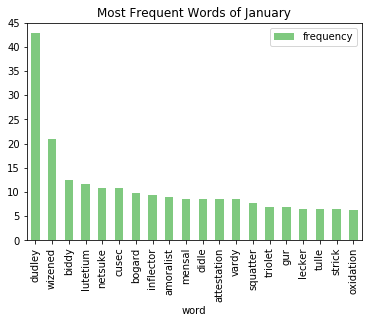

In [17]:
jan_2008_sorted = jan_2008_pd.sort_values(by=["frequency"], ascending=False)
jan_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of January", colormap="Accent")

February most frequently used 20 words:

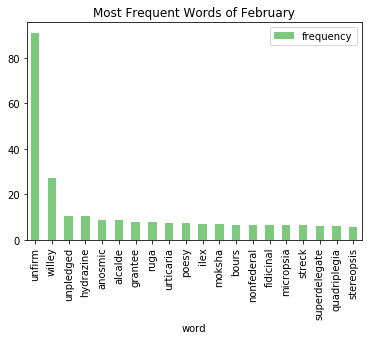

In [18]:
feb_2008_sorted = feb_2008_pd.sort_values(by=["frequency"], ascending=False)
feb_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of February", colormap="Accent")

March most frequently used 20 words:

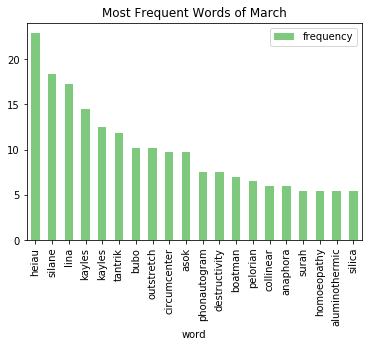

In [19]:
mar_2008_sorted = mar_2008_pd.sort_values(by=["frequency"], ascending=False)
mar_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of March", colormap="Accent")

April most frequently used 20 words:

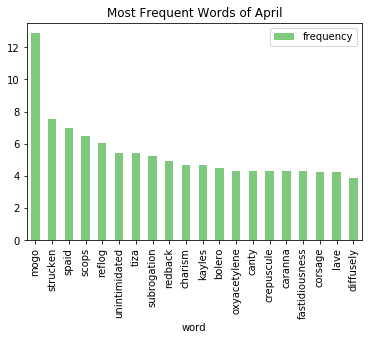

In [20]:
apr_2008_sorted = apr_2008_pd.sort_values(by=["frequency"], ascending=False)
apr_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of April", colormap="Accent")

May most frequently used 20 words:

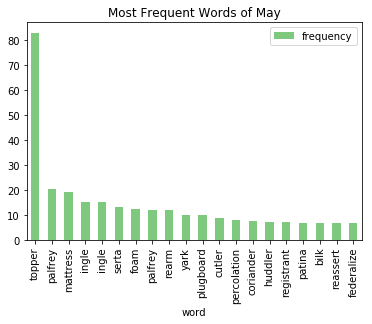

In [21]:
may_2008_sorted = may_2008_pd.sort_values(by=["frequency"], ascending=False)
may_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of May", colormap="Accent")

June most frequently used 20 words:

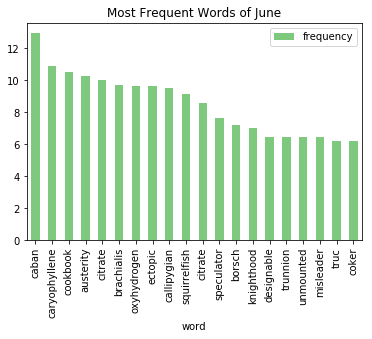

In [22]:
jun_2008_sorted = jun_2008_pd.sort_values(by=["frequency"], ascending=False)
jun_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of June", colormap="Accent")

July most frequently used 20 words:

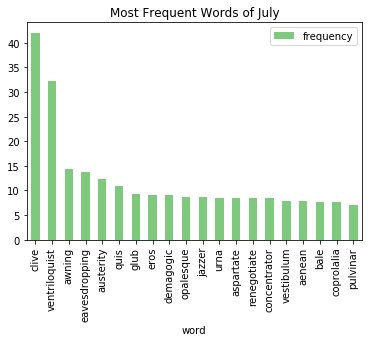

In [23]:
jul_2008_sorted = jul_2008_pd.sort_values(by=["frequency"], ascending=False)
jul_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of July", colormap="Accent")

August most frequently used 20 words:

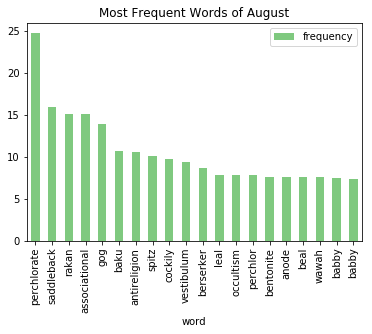

In [24]:
aug_2008_sorted = aug_2008_pd.sort_values(by=["frequency"], ascending=False)
aug_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of August", colormap="Accent")

September most frequently used 20 words:

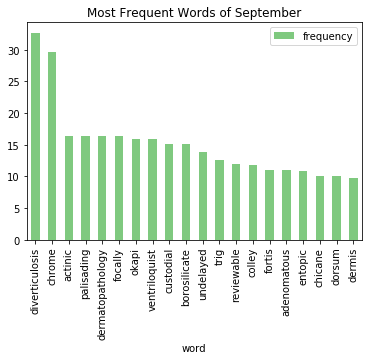

In [25]:
sep_2008_sorted = sep_2008_pd.sort_values(by=["frequency"], ascending=False)
sep_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of September", colormap="Accent")

October most frequently used 20 words:

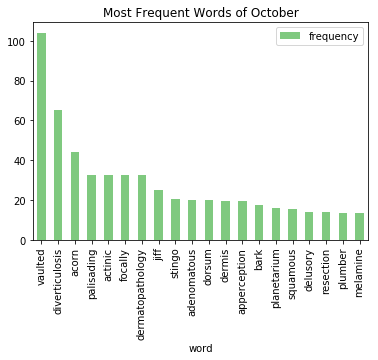

In [26]:
oct_2008_sorted = oct_2008_pd.sort_values(by=["frequency"], ascending=False)
oct_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of October", colormap="Accent")

November most frequently used 20 words:

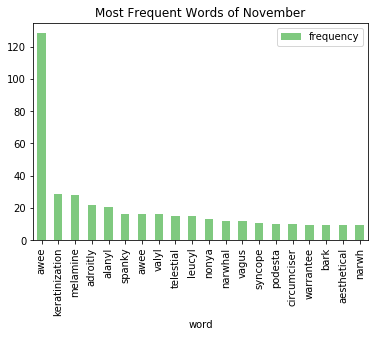

In [27]:
nov_2008_sorted = nov_2008_pd.sort_values(by=["frequency"], ascending=False)
nov_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of November", colormap="Accent")

December most frequently used 20 words:

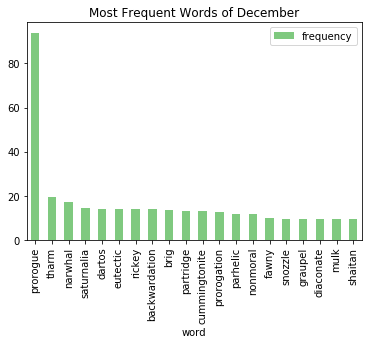

In [28]:
dec_2008_sorted = dec_2008_pd.sort_values(by=["frequency"], ascending=False)
dec_2008_sorted[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent Words of December", colormap="Accent")

Now, combine all the postive comments into a positive Dataframe, then combine all the negative comments into a negative DataFrame. Finally, combine all comments together into a total DataFrame

In [29]:
pos_words_2008_pd = pd.DataFrame(jan_pos_2008 + feb_pos_2008 + mar_pos_2008 + apr_pos_2008 + may_pos_2008 + jun_pos_2008 + jul_pos_2008 + aug_pos_2008 + sep_pos_2008 + oct_pos_2008 + nov_pos_2008 + dec_pos_2008, columns=["word", "frequency"])

neg_words_2008_pd = pd.DataFrame(jan_neg_2008 + feb_neg_2008 + mar_neg_2008 + may_neg_2008 + jun_neg_2008 + jul_neg_2008 + aug_neg_2008 + sep_neg_2008 + oct_neg_2008 + nov_neg_2008 + dec_neg_2008, columns=["word", "frequency"])

total_words_2008_pd = pd.concat([pos_words_2008_pd, neg_words_2008_pd])

Let's extract the top 20 words from positive comments and plot them in a bar graph.

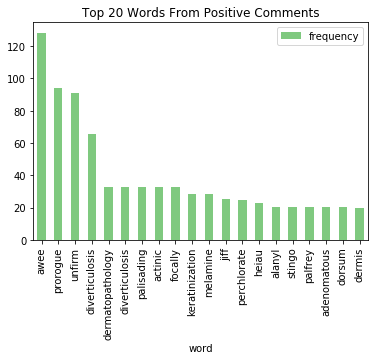

In [30]:
pos_words_2008_sorted = pos_words_2008_pd.sort_values(by=["frequency"], ascending=False)
pos_words_2008_sorted.iloc[0:20].plot(x="word", y="frequency", kind="bar", title="Top 20 Words From Positive Comments", colormap="Accent")

Let's extract the top 20 words from negative comments and plot them in a bar graph.

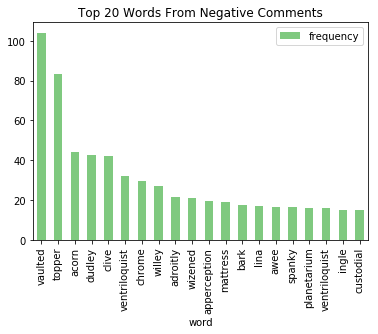

In [31]:
neg_words_2008_sorted = neg_words_2008_pd.sort_values(by=["frequency"], ascending=False)
neg_words_2008_sorted.iloc[0:20].plot(x="word", y="frequency", kind="bar", title="Top 20 Words From Negative Comments", colormap="Accent")

Lastly, lets see what the top 20 words are from all comments in 2008. Then we will plot them in a bar graph.

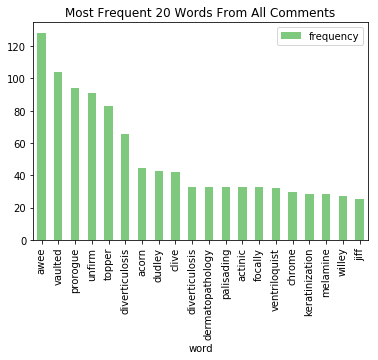

In [32]:
total_words_2008_sorted = total_words_2008_pd.sort_values(by=["frequency"], ascending=False)
total_words_2008_sorted.iloc[0:20].plot(x="word", y="frequency", kind="bar", title="Most Frequent 20 Words From All Comments", colormap="Accent")

Now, we will extract the most frequent word for positive and negative.

In [33]:
pos_most_freq = pos_words_2008_pd.loc[pos_words_2008_pd["frequency"].idxmax()]

neg_most_freq = neg_words_2008_pd.loc[neg_words_2008_pd["frequency"].idxmax()]

print(pos_most_freq)
print(neg_most_freq)

word            awee
frequency    128.346
Name: 500, dtype: object
word         vaulted
frequency    104.012
Name: 320, dtype: object


We will also quickly visualize this frequency in a final bar graph.

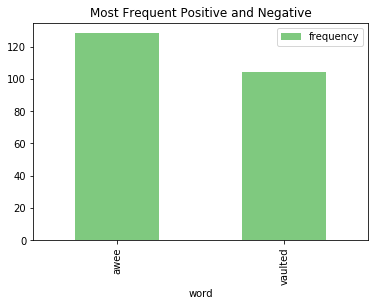

In [34]:
data = {"word": [pos_most_freq[0], neg_most_freq[0]], "frequency": [pos_most_freq[1], neg_most_freq[1]]}
top_freq = pd.DataFrame(data)
top_freq.plot(x="word", y="frequency", kind="bar", title="Most Frequent Positive and Negative", colormap="Accent")

## Finding frequency spread across 2008 comments

To see if there is a spike in popularity of certain key words, we will take a look at the average difference in frequency of the top frequent words in each month.
This way, we can essentially capture the spread of each month and see if there are any months with notably larger spread. Months with larger difference could indicate that they have certain words with much larger frequency that may result from trends or the internet topic of the month.

In [35]:
# This method calculates the average difference of the df up to count index
def average_freq_diff(df, count):
    prev_word_row = df.iloc[0]
    avg_diff = 0
    for i in range(1, count):
        curr_row = df.iloc[i]
        avg_diff += abs(prev_word_row.frequency - curr_row.frequency)
        prev_word_row = curr_row
    return (avg_diff / count)

In [36]:
data = [average_freq_diff(jan_2008_sorted, 20),
average_freq_diff(feb_2008_sorted, 20),
average_freq_diff(mar_2008_sorted, 20),
average_freq_diff(apr_2008_sorted, 20),
average_freq_diff(may_2008_sorted, 20),
average_freq_diff(jun_2008_sorted, 20),
average_freq_diff(jul_2008_sorted, 20),
average_freq_diff(aug_2008_sorted, 20),
average_freq_diff(sep_2008_sorted, 20),
average_freq_diff(oct_2008_sorted, 20),
average_freq_diff(nov_2008_sorted, 20),
average_freq_diff(dec_2008_sorted, 20)]

We will put the average difference in a DataFrame and plot the results.

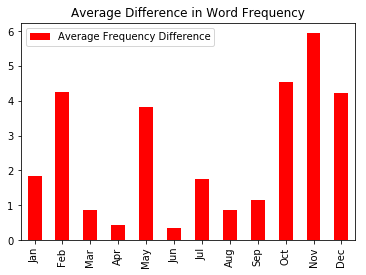

In [39]:
spread_2008_df = pd.DataFrame(data, columns=["Average Frequency Difference"], index=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
spread_2008_df.plot(y="Average Frequency Difference", kind="bar", title="Average Difference in Word Frequency", colormap="autumn")

## Comparing the overlaps between the positive and negative comments of each month

First, we want to couple the positive and negative data of each month, so it will be easy to iterate through.

In [10]:
data_set_list = [(jan_pos_2008,jan_neg_2008),(feb_pos_2008,feb_neg_2008),(mar_pos_2008,mar_neg_2008),
                (apr_pos_2008,None),(may_pos_2008,may_neg_2008),(jun_pos_2008,jun_neg_2008),
                (jul_pos_2008,jul_neg_2008),(aug_pos_2008,aug_neg_2008),(sep_pos_2008,sep_neg_2008),
                (oct_pos_2008,oct_neg_2008),(nov_pos_2008,nov_neg_2008),(dec_pos_2008,dec_neg_2008)]
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
overlap_dictionary = {}
for i in months:
    overlap_dictionary[i] = set()
    
    

We then compared the number of words that appeared in both the positive and negative lists for each month.

In [13]:
overlap_counts = []
month_counter = -1
for i in data_set_list:
    month_counter += 1
    count = 0
    if i[1] == None:
        overlap_counts.append(count)
        continue
    for j in range(40):
        for k in range(40):
            if i[0][j][0] == i[1][k][0]:
                count += 1
                overlap_dictionary[months[month_counter]].add(i[0][j][0])
    overlap_counts.append(count)


We decided that a bar graph was the best way to plot the data, as it easily shows which months had larger amounts of overlap than other months.

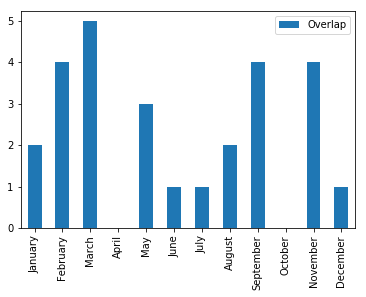

In [16]:
df = pd.DataFrame(overlap_counts, index=months)
df.columns = ["Overlap"]
df.plot.bar()

We also wanted to create a dictionary showing the words that overlaped, to see if they have any significance

In [17]:
overlap_dictionary

{'January': {'kik', 'tusked'},
 'February': {'grantee', 'nonfederal', 'superdelegate', 'willey'},
 'March': {'causey', 'colitis', 'kayles', 'reductional', 'unpledged'},
 'April': set(),
 'May': {'atchison', 'ingle', 'palfrey'},
 'June': {'citrate'},
 'July': {'riddler'},
 'August': {'babby', 'perchlorate'},
 'September': {'babby', 'chrom', 'dermis', 'diverticulosis'},
 'October': set(),
 'November': {'awee', 'keratinization', 'melamine', 'narwh'},
 'December': {'narwhal'}}

## Data Analysis & Results 

#### Regarding months with large frequency spikes
As presented in our graphs, most months have a consistent frequency amongst top 20 words with a few exceptions. In the graph for average difference, we can see a significant spike in average frequency for the months of February, May, October, November, and December. This is an indicator that perhaps there is a certain popular topic or keyword that motivated a greater frequency of usage in those months.
For the month of December, the most popular word is “prorogue” with a frequency of 93 over the second most popular word “tharm” with a frequency of 19.  Research reveals that during December of 2008, the Canadian parliament underwent prorogation that ended parliamentary session without dissolving parliament in advance of new elections. This was a key event in Canadian political history and no doubt generated a ton of reporting and chatter all over the internet. For all the other months, the spiking frequency word revealed nonsensical results without a solid connection to current events. In October 2008, “krona” appeared one of the top fifty words. In late 2008, Iceland faced a financial crisis which resulting defaulting major banks in Iceland. 

#### Regarding words with most overlaps

When analysing words that overlapped between positive and negative comments, we decided to see how many of the top 40 words overlapped for each month. We hypothesized that words that overlap are either for controversial topics, or topics that are large enough to span positive and negative comments. Therefore, months that have more overlap, in theory, could have more controversy, or more popular topics. Although this might be the case, we found it very hard to find conclusive results with the number of overlaps alone, therefore we decided to single out words that did overlap, and words that did not. For example, the word “prorogue” did not overlap despite being very popular in the positive data set for December. We can likely conclude that the event that corresponded with prorogue was generally seen as a positive event, as it was popular with the positive comments and not the negative. If we look at the words that overlap in February however, the words “superdelegate” and “nonfederal” show up. These topics both deal with elections and government. This might conclude that topics relating the government are controversial. Since we didn’t have any other data set to relate to, none of our analysis is conclusive, but the connotation of words can be inferred through the investigation of the overlap between the positive and negative comments.

## Privacy/Ethics Considerations

We have considered privacy and ethics issues surrounding several parts of our data science process:

#### Possible Data Concerns: 
The data was collected using Reddit’s public API, so we do have  permission to use this data. The data is stored on the website given above in zip files. This website has Reddit data since 2005. This may raise a privacy concern, because if a user deleted their account or a specific post after the data had been collected, their posts will still be found on the website. 

The dataset does not contain email, age, or gender of the user, but it does contain the reddit usernames, so there is not complete anonymity in this dataset. The usernames could possibly be used to track down the individual’s account and find out private information about them. To avoid this issue, we first removed the usernames from the dataset to ensure the privacy of the users. The resulting data has no link to a specific user that posted the comment.
    
#### Bias in Data:
When analyzing text data to find the most frequently used words, it is possible that outliers may appear with stopwords such as “the”, “and”, “that”, etc. These are words that are very common and will appear in every single document, and therefore may skew our data. In order to mitigate this bias, we used an algorithm to remove the stopwords in the beginning, so that we are only left with the important words. Furthermore, our algorithm for finding the most/least commonly used words compares the frequency of each word in a specific month to the entire year worth of reddit posts. This way, we are able to find only the words that are frequent and unique to that specific month. This part of the algorithm helps us eliminate words that may not be stopwords but are still quite popular in reddit posts, such as common abbreviations “LOL”, “omg”, etc. However, a consequence of the TF-IDF algorithm was that words that appeared in more than one month usually were not able to score high enough, so words that were popular in a 2-3 months only did not show up as significant. This caused our data to be skewed towards words that only showed up in one month. These words are pretty obscure, as unique words in a dataset as large as ours, are rare. 
    
#### Equitable Impact Concerns:
In general, there shouldn't be any equiatable impact from our analysis. Our analysis takes in great consideration in protecting the authors and the data is acquired through public means. The resulting analysis cannot cause any harm by avoiding all traces of personal identification. Hence, it should be equitable.


## Conclusion & Discussion

Overall, some popular words that appear tend to concentrate around a certain field or discipline. For example, in the month of November, several chemistry terms dominate the top frequency of positive comments. Similarly, in other months, there will be increases in words related to interior decorating or horse riding. This is likely due to the nature and structure of Reddit where posts and comments are concentrated in Subreddits dedicated to certain topics. Hence, the conversations tend to be more specialized.

While there are many words that reflect significant or contemporary events, most of the words, in fact, do not reflect them. Despite many cases of notable correlation to current events of 2008, such as the prorogation  of the Canadian parliament, most of the top words do not reveal a direct connection with other words of the month. Taken individually, the words reveal very little about the popular topic of conversation.

Regrettably, we do not have another data set or metric to decisively conclude the correlation of current topic versus the words that were used. However, based on the frequency and the TFIDF method, the popular words that we gathered certainly define the conversation on Reddit at that time. Therefore, the most popular words in itself is not enough to consistently reveal the trend or significant milestones of that month.

### Possible Improvements

To come to a more rigorous conclusion in regarding this research topic, it will be beneficial to have more analytical resources. While the 2008 Reddit data is enormous, it is still a lot more skewed due to how the population of early Reddit is smaller and specialized. Modern data, such as the ones in 2016 and 2018, will likely have a stronger correlation between frequent words and current topic. To analyze such data, however, will require astronomical computing power. 